# Contexto

En este notebook realizaremos la logica y paso a paso para ajustar modelos de tipo bagging a los datos,  
probar su desempeño, guardar los modelos ganadores y realizar submissions a la competencia de kaggle.

# Carga de paquetes

In [22]:
%pip install xgboost
%pip install lightgbm
%pip install --upgrade pandas dask


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import randint

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold

from sklearn.feature_selection import VarianceThreshold, SelectPercentile, chi2


# Scikit-learn models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier

# XGBoost
import xgboost as xgb

# LightGBM
import lightgbm as lgb

from scipy.stats import loguniform

from sklearn.ensemble import (
    RandomForestClassifier,
)  # Clasificador de bosque aleatorio.


from sklearn.preprocessing import (
    StandardScaler,
)  # Escalado de características para normalizar los datos.
from sklearn.preprocessing import (
    OneHotEncoder,
)  # Codificación one-hot para variables categóricas.

import sklearn.metrics as skm
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from sklearn.base import BaseEstimator, ClassifierMixin, clone

import pickle  # Serialización y deserialización de objetos Python (guardar/cargar modelos).

c:\Users\57315\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
c:\Users\57315\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (
c:\Users\57315\anaconda3\lib\site-packages\dask\dataframe\__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


# Carga de datos

In [2]:
filename = "bagging_model.ipynb"  # nombre del archivo actual
print(f"Current file name: {filename}\n")
print(f"Current absolute path: {os.getcwd()}\n")

# Especificamos la ruta del directorio actual y los directorios de datos y salida
ACTUAL_DIR = os.path.dirname(os.path.abspath(filename))
BASE_DIR = os.path.dirname(os.path.dirname(ACTUAL_DIR))
DATA_DIR = os.path.join(BASE_DIR, "Data")
MODELS_DIR = os.path.join(DATA_DIR, "models")
OUTPUT_DIR = os.path.join(DATA_DIR, "output_data")
SUB_DIR = os.path.join(DATA_DIR, "submissions")

print(f"BASE_DIR: {BASE_DIR}")
print(f"DATA_DIR: {OUTPUT_DIR}")
print(f"MODELS_DIR: {MODELS_DIR}")
print(f"SUB_DIR: {SUB_DIR}")

Current file name: bagging_model.ipynb

Current absolute path: c:\Users\57315\Documents\ICESI\SEMESTRE_I\APRENDIZAJE_AUTOMATICO_II\PROYECTO KAGGLE\competencia_ml2_icesi\Notebooks\Machine_learning

BASE_DIR: c:\Users\57315\Documents\ICESI\SEMESTRE_I\APRENDIZAJE_AUTOMATICO_II\PROYECTO KAGGLE\competencia_ml2_icesi
DATA_DIR: c:\Users\57315\Documents\ICESI\SEMESTRE_I\APRENDIZAJE_AUTOMATICO_II\PROYECTO KAGGLE\competencia_ml2_icesi\Data\output_data
MODELS_DIR: c:\Users\57315\Documents\ICESI\SEMESTRE_I\APRENDIZAJE_AUTOMATICO_II\PROYECTO KAGGLE\competencia_ml2_icesi\Data\models
SUB_DIR: c:\Users\57315\Documents\ICESI\SEMESTRE_I\APRENDIZAJE_AUTOMATICO_II\PROYECTO KAGGLE\competencia_ml2_icesi\Data\submissions


In [3]:
df = pd.read_parquet(os.path.join(OUTPUT_DIR, "df_train_clean.parquet"))
df_test = pd.read_parquet(os.path.join(OUTPUT_DIR, "df_test_clean.parquet"))

In [4]:
print(df.shape)
print()
df.info()

(3955, 39)

<class 'pandas.core.frame.DataFrame'>
Index: 3955 entries, 2987 to 898
Data columns (total 39 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   genero                      3955 non-null   object 
 1   estado_civil                3955 non-null   object 
 2   codigo_sede                 3955 non-null   object 
 3   multi_cancer                3955 non-null   int64  
 4   cesion                      3955 non-null   int64  
 5   riesgos                     3955 non-null   float64
 6   cancer_mama_familiar        3955 non-null   int64  
 7   cancer_otro_sitio           3955 non-null   int64  
 8   cancer_otro_sitio_familiar  3955 non-null   int64  
 9   cerebral_familiar           3955 non-null   int64  
 10  peso                        3955 non-null   float64
 11  talla                       3955 non-null   float64
 12  tsistolica                  3955 non-null   float64
 13  tdiastolica             

In [5]:
X = df.drop(columns=["target"])
y = df["target"]

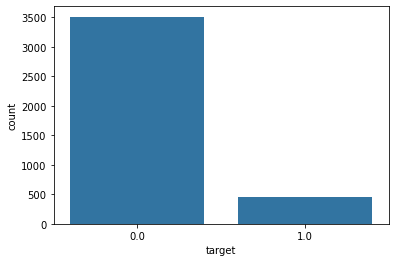

In [6]:
sns.countplot(x=y)
plt.show()

Es importante notar que estamos ante un caso de clasificación desbalanceada!

# Funciones utiles

In [7]:
def mejor_umbral(y_true, y_probs):
    """
    Calcula el mejor umbral para maximizar la métrica F1.
    """
    thresholds = np.linspace(0, 1, 1000)
    scores = [skm.f1_score(y_true, y_probs >= t) for t in thresholds]
    best_threshold = thresholds[np.argmax(scores)]

    return best_threshold

In [8]:
def evaluar_modelo_clasificacion(y_true, y_pred, y_proba=None, threshold=0.5):
    """
    Calcula y devuelve métricas para un caso de clasificación desbalanceado.

    Parámetros:
    -----------
    y_true : vector
        Valores reales o etiquetas verdaderas.
    y_pred : vector
        Valores predichos o etiquetas predichas.
    y_proba : vector, opcional
        Probabilidades predichas (para la clase positiva), útil para calcular AUC y PR-AUC.
    threshold : float, opcional
        Umbral de decisión utilizado para convertir probabilidades en etiquetas binarias.

    Retorna:
    --------
    dict
        Diccionario con las métricas calculadas: accuracy, precision, recall, f1,
        specificity, auc (si y_proba es proporcionado), pr_auc (si y_proba es proporcionado)
        y confusion_matrix.
    """
    # Métricas básicas
    accuracy = skm.accuracy_score(y_true, y_pred)
    precision = skm.precision_score(y_true, y_pred, zero_division=0)
    recall = skm.recall_score(y_true, y_pred, zero_division=0)
    f1 = skm.f1_score(y_true, y_pred, zero_division=0)
    kappa = skm.cohen_kappa_score(y_true, y_pred)

    # Matriz de confusión
    cm = skm.confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel() if cm.size == 4 else (0, 0, 0, 0)

    # Especificidad (true negative rate)
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    # Recopilar métricas en un diccionario
    metricas = {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "kappa": kappa,
        "specificity": specificity,
        "confusion_matrix": cm,
    }

    # Añadir métricas basadas en probabilidades si están disponibles
    if y_proba is not None:
        try:
            # Área bajo la curva ROC
            metricas["auc"] = skm.roc_auc_score(y_true, y_proba)

            # Área bajo la curva PR
            precision_curve, recall_curve, _ = skm.precision_recall_curve(
                y_true, y_proba
            )
            pr_auc = skm.auc(recall_curve, precision_curve)
            metricas["pr_auc"] = pr_auc
        except:
            # En caso de que haya algún error (como una sola clase presente)
            metricas["auc"] = None
            metricas["pr_auc"] = None

    metricas["threshold"] = threshold

    return metricas

In [9]:
def plot_metrics_comparison(metrics_list, minority_class_pct=None, figsize=(14, 12)):
    """
    Visualiza métricas de clasificación para uno o más modelos.

    Parámetros:
    -----------
    metrics_list : list
        Lista de diccionarios con métricas de evaluación. Cada diccionario debe tener
        una clave 'name' que identifica el modelo y las métricas estándar (accuracy,
        precision, recall, f1, etc.)

    minority_class_pct : float, opcional
        Porcentaje de la clase minoritaria en los datos (entre 0 y 1).
        Si se proporciona, se dibuja una línea de referencia en los gráficos de barras.

    figsize : tuple, opcional
        Tamaño de la figura (ancho, alto)

    Retorna:
    --------
        Figura con los gráficos de métricas
    """

    # Verificar que hay métricas para visualizar
    if not metrics_list:
        print("No hay métricas para visualizar")
        return None

    # Asegurar que todos los diccionarios tienen una clave 'name'
    for i, metrics_dict in enumerate(metrics_list):
        if "name" not in metrics_dict:
            metrics_dict["name"] = f"Modelo {i+1}"

    # Métricas para visualizar
    main_metrics = ["accuracy", "precision", "recall", "f1", "kappa"]

    # Si hay métricas basadas en probabilidades, incluirlas
    if "auc" in metrics_list[0] and metrics_list[0]["auc"] is not None:
        main_metrics.extend(["auc", "pr_auc"])

    # Crear figura y subplots
    fig, axes = plt.subplots(3, 3, figsize=figsize)
    axes = axes.flatten()

    # Colores para cada modelo
    colors = plt.cm.viridis(np.linspace(0, 1, len(metrics_list)))

    # Para cada métrica, crear un gráfico de barras
    for i, metric in enumerate(main_metrics):
        if i < len(axes):  # Asegurarse de que hay suficientes subplots
            metric_values = [m.get(metric, 0) for m in metrics_list]
            model_names = [m["name"] for m in metrics_list]

            # Crear gráfico de barras
            bars = axes[i].bar(model_names, metric_values, color=colors)

            # Añadir valores encima de las barras
            for bar, val in zip(bars, metric_values):
                axes[i].text(
                    bar.get_x() + bar.get_width() / 2,
                    bar.get_height() + 0.02,
                    f"{val:.3f}",
                    ha="center",
                    va="bottom",
                    fontsize=10,
                )

            # Añadir línea para el porcentaje de clase minoritaria (baseline accuracy)
            if minority_class_pct is not None and metric == "accuracy":
                baseline = max(minority_class_pct, 1 - minority_class_pct)
                axes[i].axhline(y=baseline, color="r", linestyle="--", alpha=0.7)
                axes[i].text(
                    0,
                    baseline + 0.02,
                    f"Baseline: {baseline:.3f}",
                    color="r",
                    ha="left",
                    va="bottom",
                )

            # Configurar el gráfico
            axes[i].set_title(f"{metric.capitalize()}")
            axes[i].set_ylim([0, 1.1])
            axes[i].spines["top"].set_visible(False)
            axes[i].spines["right"].set_visible(False)

            # Rotar etiquetas si hay muchos modelos
            if len(model_names) > 3:
                axes[i].set_xticklabels(model_names, rotation=45, ha="right")

    # Si hay matriz de confusión, mostrarla para el último modelo
    if "confusion_matrix" in metrics_list[-1]:
        cm = metrics_list[-1]["confusion_matrix"]
        last_model_name = metrics_list[-1]["name"]

        # Mostrar matriz de confusión normalizada
        if i + 1 < len(axes):
            sns.heatmap(
                cm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=axes[i + 1]
            )
            axes[i + 1].set_title(f"Matriz de Confusión\n{last_model_name}")
            axes[i + 1].set_xlabel("Predicción")
            axes[i + 1].set_ylabel("Real")
            axes[i + 1].set_xticklabels(["Neg", "Pos"])
            axes[i + 1].set_yticklabels(["Neg", "Pos"])

    # Eliminar subplots sobrantes
    for j in range(i + 2, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.suptitle(
        "Comparación de Métricas de Clasificación - En test_data", fontsize=16, y=1.05
    )
    plt.subplots_adjust(top=0.9)

    return fig

# Modelado
A continuación, procedemos con la preparación y logica para ajustar/probar modelos KNN a la data

In [10]:
# Dividimos el conjunto de datos en conjuntos de entrenamiento y prueba

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=1, stratify=y
)

print(y_train.value_counts(True) * 100)
print()
print(y_test.value_counts(True) * 100)

target
0.0    88.704692
1.0    11.295308
Name: proportion, dtype: float64

target
0.0    88.636364
1.0    11.363636
Name: proportion, dtype: float64


## Pipelines y clases

Construimos pipelines para hacer mas reproducible los entrenamientos y evitar inconvenientes.

### Pipeline pre-procesamiento

In [11]:
# Definir variables categóricas y numéricas
categoricas = X.select_dtypes(include=["object"]).columns.tolist()
numericas = X.select_dtypes(exclude=["object"]).columns.tolist()

# Configuración para OneHotEncoder
config_onehot = {"handle_unknown": "ignore"}

numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler()),
        ("select_var", VarianceThreshold(0.05)),
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("dumm", OneHotEncoder(**config_onehot)),
        ("selector", SelectPercentile(chi2, percentile=80)),
    ]
)

# Pipeline para preprocesar los datos numericos y categoricos
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numericas),
        ("cat", categorical_transformer, categoricas),
    ]
)

### Clase estimador

Desarrollaremos una clase estimador (clasificador) para que internamente al ajustarse, halle el mejor umbral de decisión para las predicciones.  
Para encontrar el mejor umbral, realizamos una logica de stratified kfold para determinar el mejor umbral   
evitando sesgarlo usando la misma data de entrenamiento.

In [12]:
class OptimalThresholdClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, base_model=None, scoring=skm.f1_score, cv_threshold=3):
        self.base_model = base_model
        self.scoring = scoring
        self.cv_threshold = cv_threshold  # número de folds para ajuste de threshold
        self.threshold_ = 0.5  # valor inicial

    def fit(self, X, y):
        self.base_model_ = clone(self.base_model)  # para evitar conflictos

        # Ajuste del modelo completo para predicción final (fuera de CV)
        self.base_model_.fit(X, y)

        self.classes_ = np.unique(y)

        # Validación cruzada para encontrar el mejor threshold
        skf = StratifiedKFold(n_splits=self.cv_threshold, shuffle=True, random_state=1)
        thresholds = []

        for train_idx, val_idx in skf.split(X, y):
            X_train_cv, X_val_cv = X[train_idx], X[val_idx]
            y_train_cv, y_val_cv = y.iloc[train_idx], y.iloc[val_idx]

            model_cv = clone(self.base_model)
            model_cv.fit(X_train_cv, y_train_cv)
            y_probs_val = model_cv.predict_proba(X_val_cv)[:, 1]

            best_thresh = mejor_umbral(y_val_cv, y_probs_val)
            thresholds.append(best_thresh)

        self.threshold_ = np.mean(thresholds)

        return self

    def predict(self, X):
        probs = self.base_model_.predict_proba(X)[:, 1]
        return (probs >= self.threshold_).astype(int)

    def predict_proba(self, X):
        return self.base_model_.predict_proba(X)

    def score(self, X, y):
        try:
            score = self.scoring(y, self.predict(X))
            if np.isnan(score):
                return 0
            return score
        except:
            return 0

### Función-modelo

Creamos una función, la cual integre los pasos de pre-procesamiento y la clase estimador.

In [13]:
def create_model(model, preprocessor):
    """
    Crea un pipeline de modelo con preprocesamiento y clasificador optimizado.
    """
    return Pipeline(
        [
            ("preprocessing", preprocessor),
            (
                "classifier",
                OptimalThresholdClassifier(
                    base_model=model, scoring=skm.f1_score, cv_threshold=3
                ),
            ),
        ]
    )

## Modelos base

Ajustamos un modelo base sobre el cual iteraremos para encontrar los mejores hiperparametros

In [14]:
# Ajustar el modelo base a los datos de entrenamiento

bagging_base_model = create_model(BaggingClassifier(), preprocessor)

bagging_base_model.fit(X_train, y_train)

threshold_optimo = bagging_base_model.named_steps["classifier"].threshold_
print("Threshold óptimo calculado:", threshold_optimo)

params = bagging_base_model.named_steps["classifier"].base_model_.get_params()
print("\nParámetros del modelo:\n", params)

Threshold óptimo calculado: 0.3670337003670337

Parámetros del modelo:
 {'bootstrap': True, 'bootstrap_features': False, 'estimator': None, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 10, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


In [15]:
# Predecimos en el conjunto de prueba
y_pred = bagging_base_model.predict(X_test)
y_proba = bagging_base_model.predict_proba(X_test)[:, 1]

# Evaluar el modelo
metrics_bagging = evaluar_modelo_clasificacion(
    y_test, y_pred, y_proba=y_proba, threshold=threshold_optimo
)
print(f"Métricas del modelo bagging:\n", metrics_bagging)

Métricas del modelo bagging:
 {'accuracy': 0.8737373737373737, 'precision': 0.43902439024390244, 'recall': 0.4, 'f1': 0.4186046511627907, 'kappa': 0.34795494961470075, 'specificity': 0.9344729344729344, 'confusion_matrix': array([[328,  23],
       [ 27,  18]], dtype=int64), 'auc': 0.7404241848686294, 'pr_auc': 0.418389379542481, 'threshold': 0.3670337003670337}


In [16]:
########
### Construimos un segundo modelo, para pruebas
#######

# Entrenamos el modelo
bagging_model_2 = create_model(BaggingClassifier(), preprocessor)
bagging_model_2.fit(X_train, y_train)

threshold_optimo = bagging_model_2.named_steps["classifier"].threshold_
print("Threshold óptimo calculado:", threshold_optimo)
params_2 = bagging_model_2.named_steps["classifier"].base_model_.get_params()
print("\nParámetros del modelo:\n", params_2)

# Predecimos en el conjunto de prueba
y_pred_2 = bagging_model_2.predict(X_test)
y_proba_2 = bagging_model_2.predict_proba(X_test)[:, 1]

# Evaluar el modelo
metrics_bagging_2 = evaluar_modelo_clasificacion(
    y_test, y_pred_2, y_proba=y_proba_2, threshold=threshold_optimo
)
print(f"\nMétricas del modelo bagging_model #2:")
print(metrics_bagging_2)

Threshold óptimo calculado: 0.3670337003670337

Parámetros del modelo:
 {'bootstrap': True, 'bootstrap_features': False, 'estimator': None, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 10, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}

Métricas del modelo bagging_model #2:
{'accuracy': 0.8838383838383839, 'precision': 0.4857142857142857, 'recall': 0.37777777777777777, 'f1': 0.425, 'kappa': 0.3615141955835962, 'specificity': 0.9487179487179487, 'confusion_matrix': array([[333,  18],
       [ 28,  17]], dtype=int64), 'auc': 0.7592909148464704, 'pr_auc': 0.49737223495269084, 'threshold': 0.3670337003670337}


## Tuneo de hiperparametros

En este punto probaremos diferentes hiperparametros y criterios para obtener los mejores resultados posibles con la data y el modelo utilizado

In [17]:
# Random Grid Search para optimizar el modelo de bagging

from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# Espacio de hiperparámetros para Bagging + Decision Tree (CART o ID3 o log_loss)
param_dist = {
    # Hiperparámetros del árbol base
    "classifier__base_model__estimator__criterion": ["gini", "entropy", "log_loss"],
    "classifier__base_model__estimator__max_depth": randint(3, 20),
    "classifier__base_model__estimator__min_samples_split": randint(2, 20),
    "classifier__base_model__estimator__min_samples_leaf": randint(1, 10),

    # Hiperparámetros del Bagging
    "classifier__base_model__n_estimators": randint(10, 100),
    "classifier__base_model__max_samples": uniform(0.5, 0.5),   # 0.5 a 1.0
    "classifier__base_model__max_features": uniform(0.5, 0.5),  # 0.5 a 1.0
    "classifier__base_model__bootstrap": [True, False],
    "classifier__base_model__bootstrap_features": [False, True],
}

# Árbol base
base_tree = DecisionTreeClassifier()

# Modelo Bagging con el árbol base
bagging_model = BaggingClassifier(
    estimator=base_tree,
    random_state=42
)

# Crear el pipeline con preprocesador y BaggingClassifier
bagging_pipeline = create_model(bagging_model, preprocessor)

# Configurar RandomizedSearchCV
n_iter_search = 30
random_search = RandomizedSearchCV(
    estimator=bagging_pipeline,
    param_distributions=param_dist,
    n_iter=n_iter_search,
    scoring="f1",
    cv=5,
    random_state=50,
    error_score="raise",
    n_jobs=-1,
    verbose=2,
)

# Entrenar el modelo
random_search.fit(X_train, y_train)

# Extraer hiperparámetros óptimos
params_opt = {
    key.replace("classifier__base_model__", ""): val
    for key, val in random_search.best_params_.items()
}
print("\nParámetros óptimos del modelo Bagging + Decision Tree:\n", params_opt)

# Mostrar mejor F1
print("\nMejor puntuación F1:", random_search.best_score_)

# Obtener mejor modelo entrenado
bagging_opt_model = random_search.best_estimator_

# Predecir y evaluar
y_pred_best = bagging_opt_model.predict(X_test)
y_proba_best = bagging_opt_model.predict_proba(X_test)[:, 1]

metrics_best_bagging_tree = evaluar_modelo_clasificacion(
    y_test, y_pred_best, y_proba=y_proba_best
)



Fitting 5 folds for each of 30 candidates, totalling 150 fits

Parámetros óptimos del modelo Bagging + Decision Tree:
 {'bootstrap': True, 'bootstrap_features': True, 'estimator__criterion': 'log_loss', 'estimator__max_depth': 10, 'estimator__min_samples_leaf': 5, 'estimator__min_samples_split': 16, 'max_features': 0.6732706022813486, 'max_samples': 0.6758824087482812, 'n_estimators': 16}

Mejor puntuación F1: 0.5530908168069498


In [18]:
metrics_best_bagging_tree   

{'accuracy': 0.8964646464646465,
 'precision': 0.5714285714285714,
 'recall': 0.35555555555555557,
 'f1': 0.4383561643835616,
 'kappa': 0.38472032742155526,
 'specificity': 0.9658119658119658,
 'confusion_matrix': array([[339,  12],
        [ 29,  16]], dtype=int64),
 'auc': 0.7950617283950617,
 'pr_auc': 0.4837403774885584,
 'threshold': 0.5}

## Comparación y selección

Comparamos el resultado de diferentes modelos para escoger aquellos que usaremos para aplicar submissions

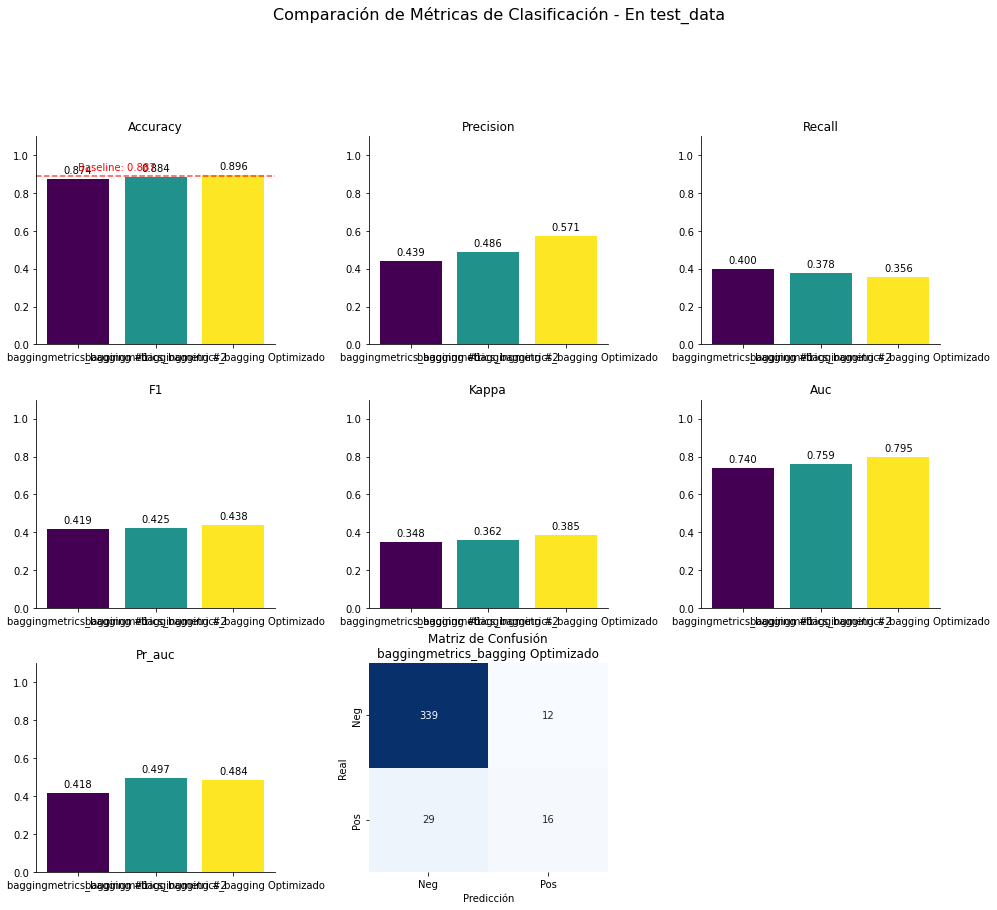

In [19]:
metrics_bagging["name"] = "baggingmetrics_bagging #1"
metrics_bagging_2["name"] = "baggingmetrics_bagging #2"
metrics_best_bagging_tree["name"] = "baggingmetrics_bagging Optimizado"

fig = plot_metrics_comparison(
    [metrics_bagging, metrics_bagging_2, metrics_best_bagging_tree],
    minority_class_pct=y_train.value_counts(normalize=True)[1],
    figsize=(14, 12),
)

# Guardar mejor modelo

In [20]:
# El mejor modelo lo re-entrenamos con toda la data disponible,
# usando el threshold óptimo y los parametros óptimos

bagging_final_model = create_model(
    BaggingClassifier(),
    preprocessor,
)

bagging_final_model.fit(X, y)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler()),
                                                                  ('select_var',
                                                                   VarianceThreshold(threshold=0.05))]),
                                                  ['multi_cancer', 'cesion',
                                                   'riesgos',
                                                   'cancer_mama_familiar',
                                                   'cancer_otro_sitio',
                                                   'cancer_otro_sitio_familiar',
                                                   'cerebral_familiar', 'peso',
                                                   'talla', 'tsistolica',...
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('dumm',
                                                                   OneHotEncoder(handle_unknown='ignore')),
                                                                  ('selector',
                                                                   SelectPercentile(percentile=80,
                                                                                    score_func=<function chi2 at 0x00000165818C5670>))]),
                                                  ['genero', 'estado_civil',
                                                   'codigo_sede',
                                                   'atencion_nutricion'])])),
                ('classifier',
                 OptimalThresholdClassifier(base_model=BaggingClassifier()))])

In [21]:
# Guardar como .pickle el modelo con mejor f1-score

time = pd.Timestamp.now().strftime("%Y_%m_%d__%H")
name = f"ctree_id3_model_{time}.pickle"

with open(os.path.join(MODELS_DIR, name), "wb") as f:
    pickle.dump(bagging_final_model, f)

# Submission

In [22]:
# Utilizamos el mejor modelo para predecir en el conjunto df_test
y_pred_submission = bagging_final_model.predict(df_test)
submission = pd.DataFrame(
    {
        "ID": df_test.index,
        "Target": y_pred_submission,
    }
)
print(submission.sample(5))

# Guardar resultados como .csv
submission.to_csv(
    os.path.join(SUB_DIR, f"submission_bagging_{time}.csv"), index=False, sep=","
)

        ID  Target
1525  1235       0
1109  1321       0
1414  5898       0
548   1271       0
684   4129       0


## Conclusiones